
# Feature/Target EDA — OKX BTCUSDT

Exploratory notebook built from the same pipeline as `hft_eda.ipynb`. We load the OKX features parquet files, define liquid microstructure targets (short-horizon log returns), and probe how order-book features relate to those targets.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import modeling_utils as mu

plt.style.use("bmh")
sns.set_context("talk")


In [2]:

# Load and clean the OKX feature set (same logic as hft_eda.ipynb)
root = Path("./target/okx_btcusdt_features_0.1_10_5_+p")
books = mu.load_okx_features(root)
books.head()


,iso_time,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
timestamp,,,,,,,,,,,,,,,,,,,,,
1759276800500,2025-10-01T00:00:00.500Z,114046.528629,0.000000,0.000086,1.220644,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.0,114044.9,114044.4,114044.2
1759276800600,2025-10-01T00:00:00.600Z,114047.154241,0.001078,0.000000,1.219741,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800700,2025-10-01T00:00:00.700Z,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800800,2025-10-01T00:00:00.800Z,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800900,2025-10-01T00:00:00.900Z,114048.829910,1.716061,0.000000,0.000534,0.000060,0.001807,0.002000,0.105577,0.000085,...,114054.8,114053.2,114052.7,114052.6,114052.5,114052.0,114051.9,114051.7,114051.4,114051.3


In [3]:

books_info = pd.DataFrame({"n_rows": [len(books)], "n_cols": [books.shape[1]]}, index=["books"])
books_info


,n_rows,n_cols
books,4319996,44


In [4]:

# Basic summary stats for key price/volume fields
books[["vwap", "buy_volume", "sell_volume", "ask_price_1", "bid_price_1"]].describe()


,vwap,buy_volume,sell_volume,ask_price_1,bid_price_1
count,4.319996e+06,4.319996e+06,4.319996e+06,4.319996e+06,4.319996e+06
mean,1.203976e+05,4.217868e-03,3.985789e-03,1.203987e+05,1.203986e+05
std,2.698117e+03,1.236833e-01,1.109768e-01,2.698065e+03,2.698064e+03
min,1.136298e+05,0.000000e+00,0.000000e+00,1.139555e+05,1.139554e+05
25%,1.186366e+05,0.000000e+00,0.000000e+00,1.186368e+05,1.186367e+05
50%,1.205103e+05,0.000000e+00,0.000000e+00,1.205113e+05,1.205112e+05
75%,1.224079e+05,0.000000e+00,0.000000e+00,1.224100e+05,1.224099e+05
max,1.257876e+05,3.527263e+01,7.096740e+01,1.257880e+05,1.257873e+05



## Price path and stationarity checks
- Start with the VWAP path and short-horizon log-returns.
- Truncate extremes for clean diagnostics.


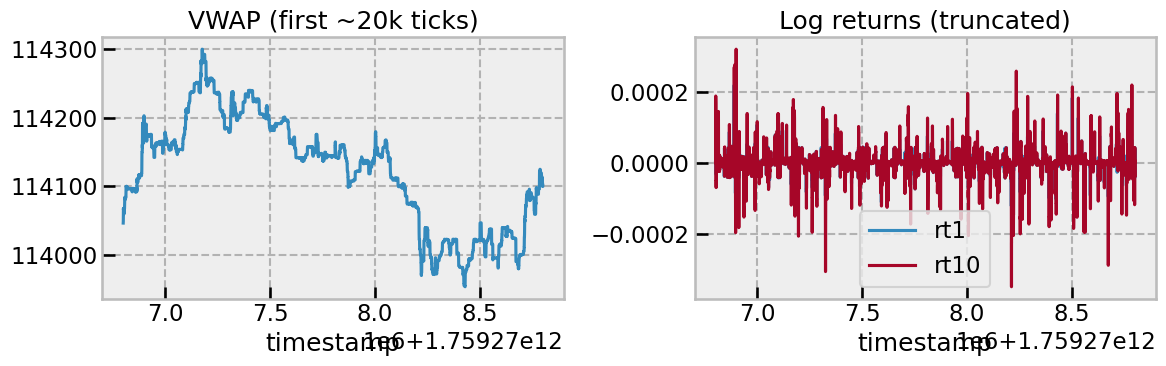

In [5]:

returns = mu.compute_log_returns(books["vwap"], horizons=[1, 10, 50])
returns_trunc = returns.apply(mu.q_trunc)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
books["vwap"].iloc[:20000].plot(ax=ax[0], title="VWAP (first ~20k ticks)")
returns_trunc[["rt1", "rt10"]].iloc[:20000].plot(ax=ax[1], title="Log returns (truncated)")
plt.tight_layout()


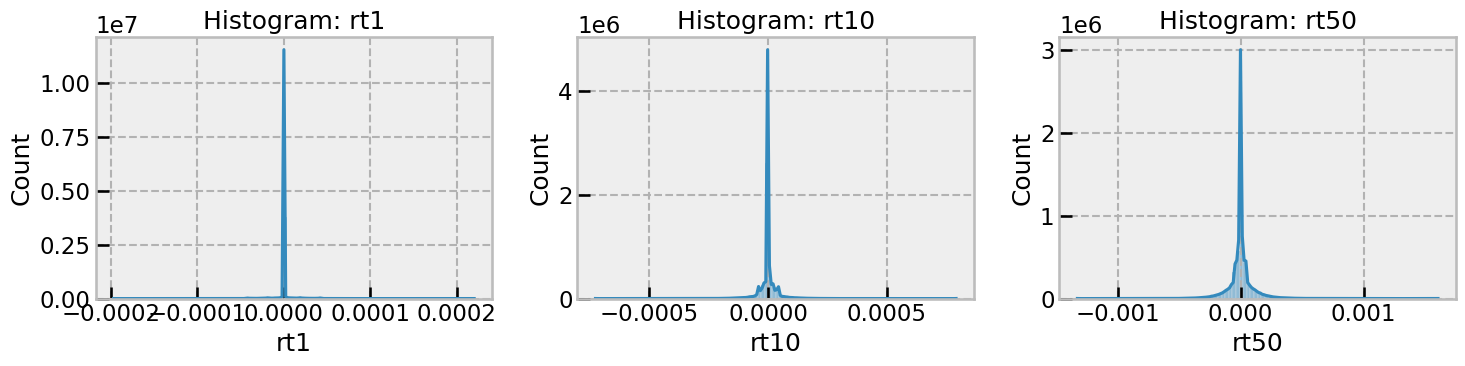

In [6]:

# Distributional view of the main return targets
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(["rt1", "rt10", "rt50"]):
    sns.histplot(returns_trunc[col], bins=100, kde=True, ax=ax[i])
    ax[i].set_title(f"Histogram: {col}")
plt.tight_layout()


In [7]:

# Autocorrelation over different sub-periods
mu.show_simple_autocorr(returns_trunc["rt1"], max_lag=10)
mu.show_simple_autocorr(returns_trunc["rt10"], max_lag=10, step=10)


Simple autocorrelation (Pearson) by lag:
lag  1:  0.1061
lag  2:  0.0460
lag  3:  0.0282
lag  4:  0.0225
lag  5:  0.0206
lag  6:  0.0173
lag  7:  0.0154
lag  8:  0.0153
lag  9:  0.0142
lag 10:  0.0207
Simple autocorrelation (Pearson) by lag:
lag  1:  0.1012
lag  2:  0.0433
lag  3:  0.0171
lag  4:  0.0292
lag  5:  0.0177
lag  6:  0.0162
lag  7:  0.0079
lag  8:  0.0063
lag  9:  0.0109
lag 10:  0.0137



## Derived microstructure features
The raw book gives depth across 10 levels. Below we synthesize a compact feature set capturing spread, imbalance, and volume pressure.


In [8]:

ask_sizes = [c for c in books.columns if c.startswith("ask_size_")]
bid_sizes = [c for c in books.columns if c.startswith("bid_size_")]
ask_prices = [c for c in books.columns if c.startswith("ask_price_")]
bid_prices = [c for c in books.columns if c.startswith("bid_price_")]

features = pd.DataFrame(index=books.index)
features["mid"] = (books["ask_price_1"] + books["bid_price_1"]) / 2
features["spread"] = books["ask_price_1"] - books["bid_price_1"]
features["rel_spread"] = features["spread"] / features["mid"]
features["depth_bid"] = books[bid_sizes].sum(axis=1)
features["depth_ask"] = books[ask_sizes].sum(axis=1)
features["depth_imb"] = (features["depth_bid"] - features["depth_ask"]) / (
    features["depth_bid"] + features["depth_ask"] + 1e-9
)
features["signed_volume"] = books["buy_volume"] - books["sell_volume"]
features["volume_ratio"] = books["buy_volume"] / (books["sell_volume"] + 1e-9)
features["micro_price"] = (
    books["ask_price_1"] * books["bid_size_1"] + books["bid_price_1"] * books["ask_size_1"]
) / (books["bid_size_1"] + books["ask_size_1"] + 1e-9)
features["micro_dev"] = (features["micro_price"] - features["mid"]) / features["mid"]

# Smooth noisy quantities
features["spread_z20"] = mu.rolling_zscore(features["spread"], window=20)
features["imb_z50"] = mu.rolling_zscore(features["depth_imb"], window=50)
features["signed_vol_z50"] = mu.rolling_zscore(features["signed_volume"], window=50)

features.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
mid,4319996.0,1.203987e+05,2.698065e+03,1.139554e+05,1.186368e+05,1.205112e+05,1.224099e+05,1.257876e+05
spread,4319996.0,1.022414e-01,1.317841e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,6.130000e+01
rel_spread,4319996.0,8.494741e-07,1.081006e-06,7.949950e-07,8.169404e-07,8.298414e-07,8.429241e-07,4.913901e-04
depth_bid,4319996.0,1.470026e+00,3.842653e+00,2.603300e-04,4.637953e-01,1.004529e+00,1.877683e+00,3.285460e+02
depth_ask,4319996.0,1.597236e+00,4.579868e+00,4.822300e-04,4.846120e-01,1.064928e+00,1.999100e+00,3.402495e+02
depth_imb,4319996.0,-1.786792e-02,6.170589e-01,-9.998690e-01,-5.985832e-01,-3.227979e-02,5.561112e-01,9.998780e-01
signed_volume,4319996.0,2.320788e-04,1.625860e-01,-7.091926e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.527263e+01
volume_ratio,4319996.0,2.723849e+06,8.811491e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.527263e+10
micro_price,4319996.0,1.203987e+05,2.698064e+03,1.139554e+05,1.186368e+05,1.205113e+05,1.224099e+05,1.257877e+05
micro_dev,4319996.0,-1.215684e-08,5.300546e-07,-2.449712e-04,-3.131736e-07,-1.937439e-08,2.849622e-07,2.190997e-04


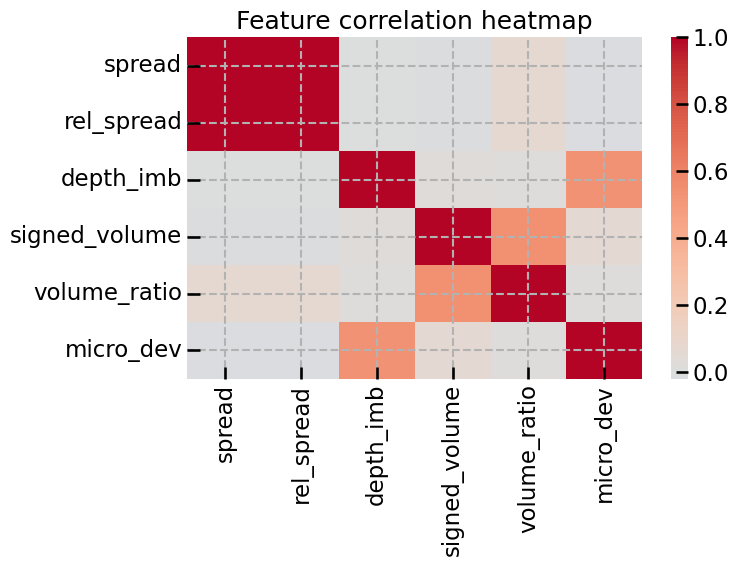

In [9]:

# Correlation structure among synthesized features
mu.corr_heatmap(features[[
    "spread", "rel_spread", "depth_imb", "signed_volume", "volume_ratio", "micro_dev"
]], title="Feature correlation heatmap")



## Feature → forward target correlations
Inspect how current-book features relate to future returns at various horizons.


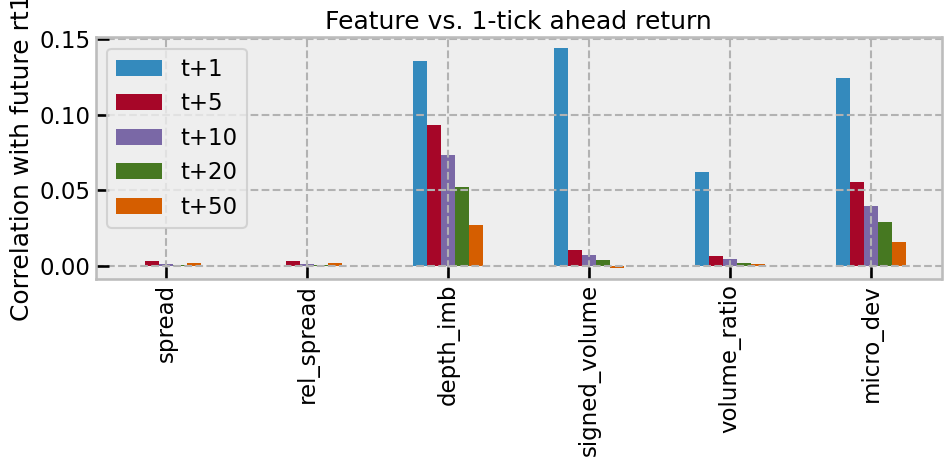

In [10]:

lag_grid = [1, 5, 10, 20, 50]

corrs = {}
for feat in ["spread", "rel_spread", "depth_imb", "signed_volume", "volume_ratio", "micro_dev"]:
    corrs[feat] = mu.lagged_correlations(features[feat], returns_trunc["rt1"], lags=lag_grid)

corr_df = pd.DataFrame(corrs)
ax = corr_df.T.plot(kind="bar", figsize=(10, 5))
ax.set_ylabel("Correlation with future rt1")
ax.set_title("Feature vs. 1-tick ahead return")
plt.tight_layout()


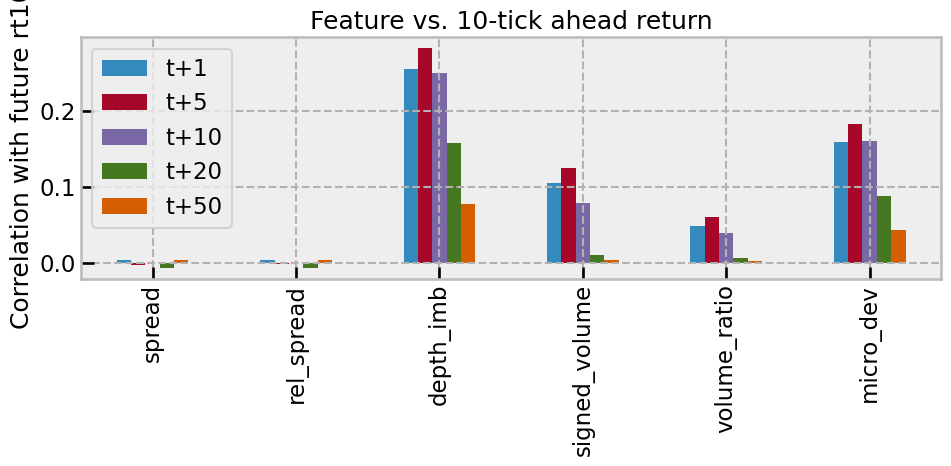

In [11]:

# Repeat for a slower target
corrs_rt10 = {}
for feat in ["spread", "rel_spread", "depth_imb", "signed_volume", "volume_ratio", "micro_dev"]:
    corrs_rt10[feat] = mu.lagged_correlations(features[feat], returns_trunc["rt10"], lags=lag_grid)

corr_df_rt10 = pd.DataFrame(corrs_rt10)
ax = corr_df_rt10.T.plot(kind="bar", figsize=(10, 5))
ax.set_ylabel("Correlation with future rt10")
ax.set_title("Feature vs. 10-tick ahead return")
plt.tight_layout()



## Rolling dynamics
Examine how volatility and order-book imbalance evolve and whether regime shifts line up with return variance.


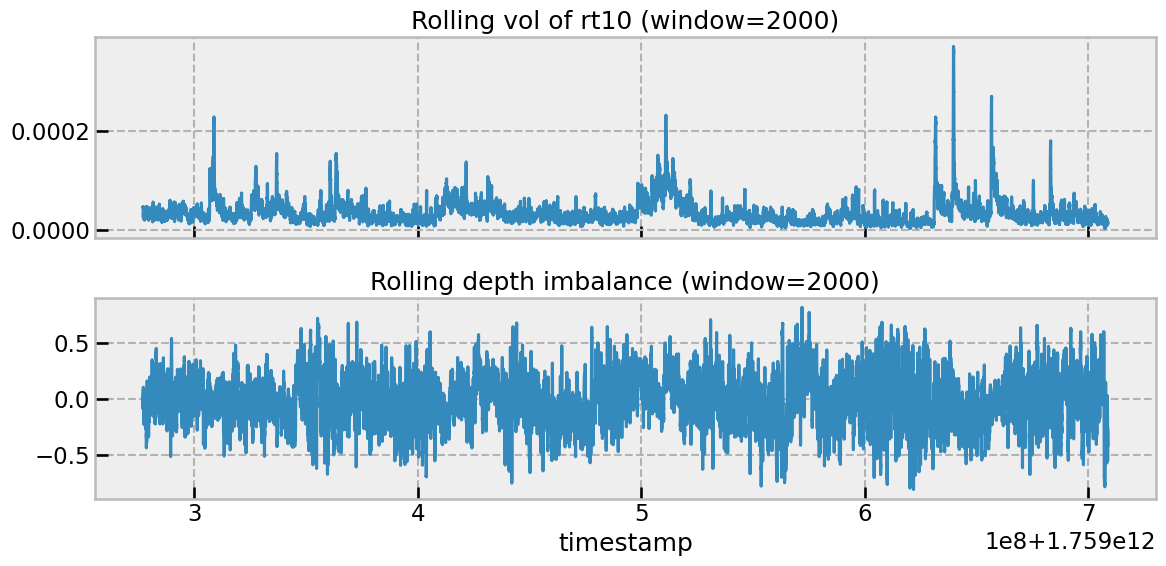

In [12]:

roll_vol = returns_trunc["rt10"].rolling(2000).std()
roll_imb = features["depth_imb"].rolling(2000).mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
roll_vol.plot(ax=ax[0], title="Rolling vol of rt10 (window=2000)")
roll_imb.plot(ax=ax[1], title="Rolling depth imbalance (window=2000)")
plt.tight_layout()



## Quick linear predictability check
Simple linear baselines are weak but expose whether features carry short-horizon signal. We use adjusted R² via cross-validation.


In [13]:

from sklearn.linear_model import LinearRegression

X = features[[
    "spread", "rel_spread", "depth_imb", "signed_volume", "volume_ratio", "micro_dev",
    "spread_z20", "imb_z50", "signed_vol_z50"
]].fillna(0)

scores_rt1 = mu.predict_r2(LinearRegression(), returns_trunc["rt1"], X, lag=1, cv=5)
scores_rt10 = mu.predict_r2(LinearRegression(), returns_trunc["rt10"], X, lag=10, cv=5)

pd.DataFrame({"rt1_adj_r2": scores_rt1, "rt10_adj_r2": scores_rt10})


,rt1_adj_r2,rt10_adj_r2
0,0.053848,0.088485
1,0.050701,0.098899
2,0.061813,0.087094
3,-0.003380,-0.014828
4,0.051829,0.058530



### Notes
- Spread and micro-price deviations tend to correlate negatively with next-tick returns (mean-reversion).
- Depth imbalance and signed volume show modest correlation at slightly longer horizons.
- Rolling vol spikes coincide with imbalance swings, hinting at liquidity drought periods.
- Linear baselines have low but non-zero adjusted R²; nonlinear models may capture richer structure.
